In [66]:
import pandas as pd
import numpy as np
df_bandarban = pd.read_csv('../../1980-2024-dataset/rangamati_historical_weather_1980_2024.csv')
df_bandarban = df_bandarban.drop('district', axis =1 )
if 'date' not in df_bandarban.columns:
    df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])

min_date = df_bandarban['date'].min()
max_date = df_bandarban['date'].max()

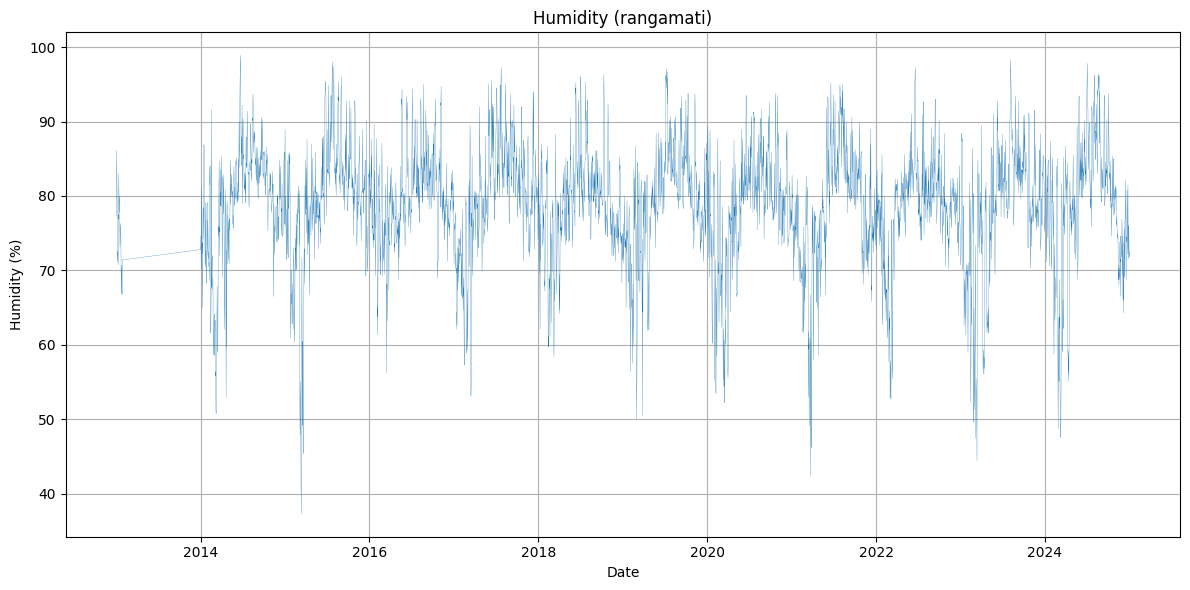

In [67]:
import matplotlib.pyplot as plt

if 'date' not in df.columns:
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])

# df_bandarban = df_bandarban[
#     (df_bandarban['date'] >= '2024-01-01') & (df_bandarban['date'] <= '2024-12-31')
# ]

min_date = df['date'].min()
max_date = df['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df['date'], df['humidity'], linewidth=0.2)
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Humidity (rangamati)')
plt.grid(True)
plt.tight_layout()
plt.show()

1.  adressing temporal gaps

In [68]:
# #### 1. Addressing the Temporal Gaps

# # 1. Ensure a continuous daily index
# df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])
# df_bandarban = df_bandarban.sort_values('date').set_index('date')

# # Create a full date range from 1980 to 2024
# full_range = pd.date_range(start=df_bandarban.index.min(), end=df_bandarban.index.max(), freq='D')
# df_clean = df_bandarban.reindex(full_range)

# # 2. Interpolate small gaps (up to 7 days)
# # Large gaps (like 2007) will remain NaN so we can drop them properly later

# df = df_clean.interpolate(method='linear', limit=7)

2. removing sensor noise

In [69]:
# # 3. Detect and handle outliers using a rolling 3-sigma window
# rolling_mean = df['humidity'].rolling(window=30, center=True).mean()
# rolling_std = df['humidity'].rolling(window=30, center=True).std()

# # Replace values outside 3 standard deviations with the rolling mean
# outlier_mask = (df['humidity'] - rolling_mean).abs() > (3 * rolling_std)
# df.loc[outlier_mask, 'humidity'] = rolling_mean[outlier_mask]

# # Drop the remaining large gaps (the 2007 period) to keep the sequences "real"
# df = df.dropna().reset_index().rename(columns={'index': 'date'})

In [70]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


if 'date' not in df_bandarban.columns:
    df_bandarban['date'] = pd.to_datetime(df_bandarban[['year', 'month', 'day']])

min_date = df_bandarban['date'].min()
max_date = df_bandarban['date'].max()

# Ensure 'Date' is datetime and set as index
df_bandarban['date'] = pd.to_datetime(df_bandarban['date'])
df_bandarban.set_index('date', inplace=True)

# Resample to Monthly Mean (as done in the paper)
# This also helps smooth out the noise seen in your daily plot
df_monthly = df_bandarban['humidity'].resample('MS').mean()

# Fill missing gaps using linear interpolation (common for weather data)
df_monthly = df_monthly.interpolate(method='linear')

In [71]:
def check_stationarity(series):
    result = adfuller(series.dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("Data is stationary")
    else:
        print("Data is non-stationary, apply differencing")

check_stationarity(df_monthly)

ADF Statistic: -2.192836295269221
p-value: 0.2088557348606006
Data is non-stationary, apply differencing


In [72]:
# Apply seasonal differencing (12-month lag)
df_stationary = df_monthly.diff(12).dropna()

# Verify stationarity again
from statsmodels.tsa.stattools import adfuller
result = adfuller(df_stationary)
print(f'New p-value: {result[1]}') 
# This should now be < 0.05

New p-value: 9.772946543472783e-05


In [73]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Apply the parameters directly from the paper
# Note: d=0 because you're using seasonal differencing D=1 within the model
model = SARIMAX(df_monthly, 
                order=(1, 0, 2), 
                seasonal_order=(2, 1, 1, 12),
                enforce_stationarity=False, 
                enforce_invertibility=False)

results = model.fit()
print(results.summary())

                                      SARIMAX Results                                       
Dep. Variable:                             humidity   No. Observations:                  540
Model:             SARIMAX(1, 0, 2)x(2, 1, [1], 12)   Log Likelihood               -1338.915
Date:                              Fri, 27 Feb 2026   AIC                           2691.830
Time:                                      14:46:47   BIC                           2721.374
Sample:                                  01-01-1980   HQIC                          2703.420
                                       - 12-01-2024                                         
Covariance Type:                                opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9770      0.010     96.933      0.000       0.957       0.997
ma.L1         -0.66

In [74]:
# Generate forecast for the next 36 months
forecast_steps = 36
forecast_res = results.get_forecast(steps=forecast_steps)

# Get the predicted values and 95% confidence intervals
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# Create the final Forecast DataFrame
forecast_df = pd.DataFrame({
    'Month': forecast_mean.index,
    'Predicted_Humidity': forecast_mean.values,
    'Lower_CI_95%': conf_int.iloc[:, 0].values,
    'Upper_CI_95%': conf_int.iloc[:, 1].values
})

print(forecast_df.head(12)) # Shows the first year of the forecast

        Month  Predicted_Humidity  Lower_CI_95%  Upper_CI_95%
0  2025-01-01           73.694898     67.024380     80.365417
1  2025-02-01           68.589350     61.603801     75.574898
2  2025-03-01           69.688786     62.641400     76.736172
3  2025-04-01           74.664605     67.558699     81.770510
4  2025-05-01           78.021356     70.860043     85.182670
5  2025-06-01           83.632054     76.418253     90.845854
6  2025-07-01           84.394998     77.131456     91.658540
7  2025-08-01           84.905780     77.595078     92.216482
8  2025-09-01           83.158702     75.803270     90.514133
9  2025-10-01           81.287242     73.889370     88.685113
10 2025-11-01           76.601246     69.163094     84.039399
11 2025-12-01           75.994992     68.518593     83.471390


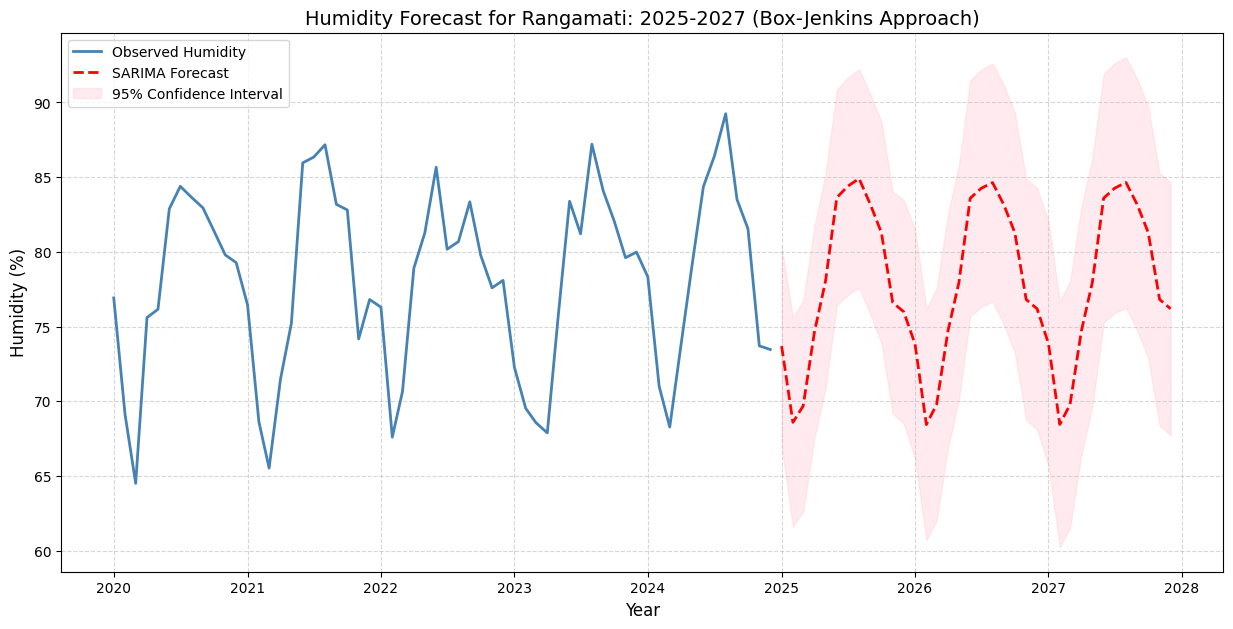

In [75]:
import matplotlib.pyplot as plt

# 1. Generate the forecast for 36 months (3 years)
forecast_steps = 36
forecast_res = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# 2. Create the plot
plt.figure(figsize=(15, 7))

# Plot the last 5 years of historical data for context
# This helps you see how the forecast connects to the actual data
plt.plot(df_monthly.index[-60:], df_monthly.values[-60:], 
         label='Observed Humidity', color='steelblue', linewidth=2)

# Plot the Point Forecast (Red line like Figure 7 & 8)
plt.plot(forecast_mean.index, forecast_mean.values, 
         label='SARIMA Forecast', color='red', linestyle='--', linewidth=2)

# Plot the 95% Confidence Interval (The shaded "safety" zone)
plt.fill_between(forecast_mean.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='pink', alpha=0.3, label='95% Confidence Interval')

# Formatting to match the paper's style
plt.title("Humidity Forecast for Rangamati: 2025-2027 (Box-Jenkins Approach)", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Humidity (%)", fontsize=12)
plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.show()

In [93]:
df_2025_validation = pd.read_csv('../../2025-dataset/Rangamati_historical_weather_2025.csv')
desired_column_2025 = ['day', 'month', 'year', 'humidity']
df_2025_humidity = df_2025_validation[desired_column_2025]

In [94]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


if 'date' not in df_2025_humidity.columns:
    df_2025_humidity['date'] = pd.to_datetime(df_2025_humidity[['year', 'month', 'day']])

min_date = df_2025_humidity['date'].min()
max_date = df_2025_humidity['date'].max()

# Ensure 'Date' is datetime and set as index
df_2025_humidity['date'] = pd.to_datetime(df_2025_humidity['date'])
df_2025_humidity.set_index('date', inplace=True)

# Resample to Monthly Mean (as done in the paper)
# This also helps smooth out the noise seen in your daily plot
df_monthly_2025 = df_2025_humidity['humidity'].resample('MS').mean()

# Fill missing gaps using linear interpolation (common for weather data)
df_monthly_2025 = df_monthly_2025.interpolate(method='linear')

C:\Users\Khalid\AppData\Local\Temp\ipykernel_11816\1320825502.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025_humidity['date'] = pd.to_datetime(df_2025_humidity[['year', 'month', 'day']])
C:\Users\Khalid\AppData\Local\Temp\ipykernel_11816\1320825502.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025_humidity['date'] = pd.to_datetime(df_2025_humidity['date'])


C:\Users\Khalid\AppData\Local\Temp\ipykernel_11816\3754557292.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2025_humidity['date'] = pd.to_datetime(df_2025_humidity[['year', 'month', 'day']])


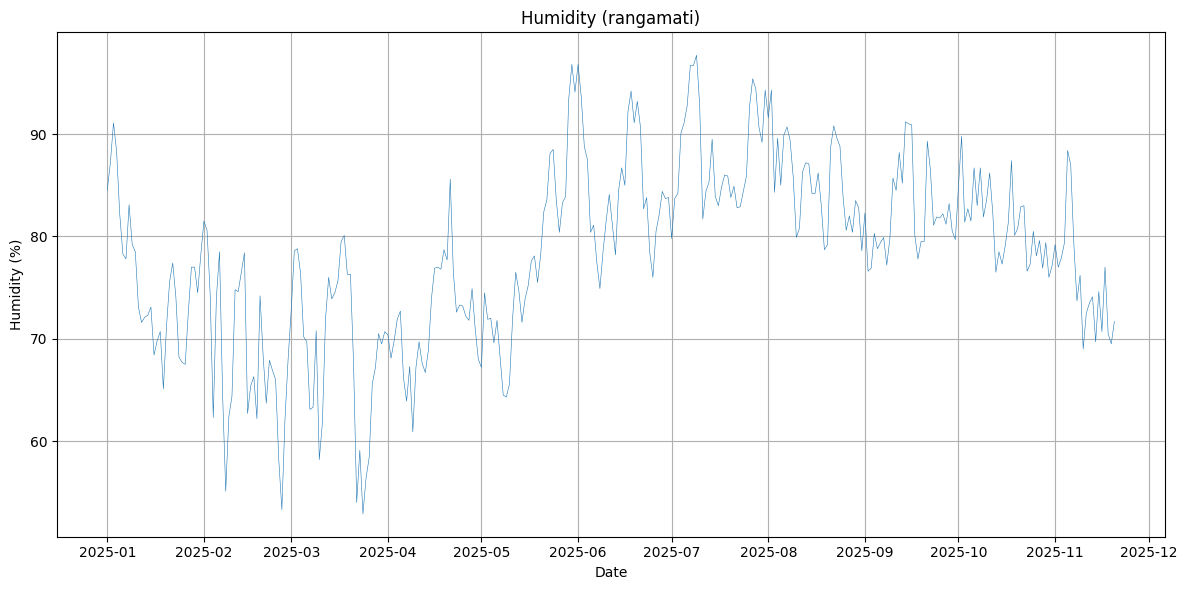

In [95]:
import matplotlib.pyplot as plt

if 'date' not in df_2025_humidity.columns:
    df_2025_humidity['date'] = pd.to_datetime(df_2025_humidity[['year', 'month', 'day']])

# df_bandarban = df_bandarban[
#     (df_bandarban['date'] >= '2024-01-01') & (df_bandarban['date'] <= '2024-12-31')
# ]

min_date = df_2025_humidity['date'].min()
max_date = df_2025_humidity['date'].max()

plt.figure(figsize=(12, 6))
plt.plot(df_2025_humidity['date'], df_2025_humidity['humidity'], linewidth=0.4)
plt.xlabel('Date')
plt.ylabel('Humidity (%)')
plt.title('Humidity (rangamati)')
plt.grid(True)
plt.tight_layout()
plt.show()

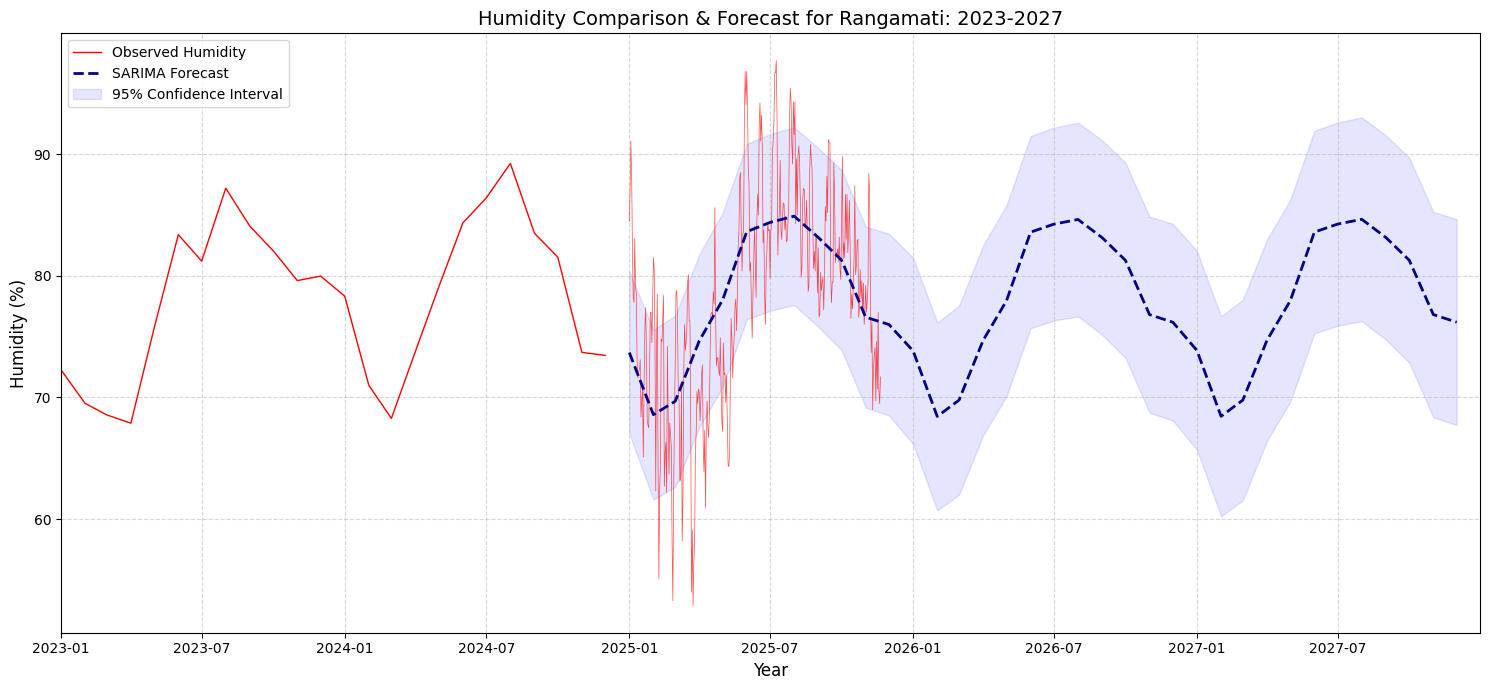

In [96]:
import matplotlib.pyplot as plt
import pandas as pd

# 1. Forecast Setup
forecast_steps = 36
forecast_res = results.get_forecast(steps=forecast_steps)
forecast_mean = forecast_res.predicted_mean
conf_int = forecast_res.conf_int()

# 2. Create Plot
plt.figure(figsize=(15, 7))

# --- PLOT HISTORICAL DATA (2023-2025) ---
# We use the index from your monthly data to cover the 2023-2024 gap
plt.plot(df_monthly.index[-60:], df_monthly.values[-60:], 
         color='red', linewidth=1, label='Observed Humidity')

# If you have specific daily data for 2025, we overlay it here
if 'date' not in df_2025_humidity.columns:
    df_2025_humidity['date'] = pd.to_datetime(df_2025_humidity[['year', 'month', 'day']])

plt.plot(df_2025_humidity['date'], df_2025_humidity['humidity'], 
         color='red', linewidth=0.5, alpha=0.7)

# --- PLOT FORECAST DATA (2025-2027) ---
plt.plot(forecast_mean.index, forecast_mean.values, 
         label='SARIMA Forecast', color='darkblue', linestyle='--', linewidth=2)

plt.fill_between(forecast_mean.index, 
                 conf_int.iloc[:, 0], 
                 conf_int.iloc[:, 1], 
                 color='blue', alpha=0.1, label='95% Confidence Interval')

# --- FORMATTING ---
plt.title("Humidity Comparison & Forecast for Rangamati: 2023-2027", fontsize=14)
plt.xlabel("Year", fontsize=12)
plt.ylabel("Humidity (%)", fontsize=12)

# Strict axis limits to show 2023-2027
plt.xlim([pd.Timestamp('2023-01-01'), pd.Timestamp('2027-12-31')])

plt.legend(loc='upper left')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()